<h1> Experiment 1 </h1>

# Part 1: Pre-training the encoder using SimCLR

set up the environment

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from SimCLR_data_util import preprocess_for_train
from resnet_small import ResNet18
from tensorflow.keras.layers import Dense
from SimCLR import SimCLR

In [2]:
tf.__version__

'2.6.0'

Get the dataset:

In [3]:
from datasets.cifar_10 import get_unsupervised_dataset
dataset = get_unsupervised_dataset(batch_size=64)          # increase batch size if GPU memory available

## Augmentations 
Build the random augmentation layer. In this case, the augmentations are based on a composition of randomly applied crops, collor jitter, reflection, gaussian blur, etc.

In [4]:
class MyAugmentation(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
    
    def call(self, x):
        augment_image = lambda im: preprocess_for_train(im, 32, 32)
        return tf.map_fn(augment_image, x)

augmentation = MyAugmentation()

Here is an example of the original compared to the augmented image

Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use `tf.cast` instead.


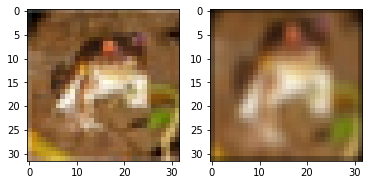

In [5]:
batch = next(iter(dataset))
batch_augmented = augmentation(batch)
fix, (axis1, axis2) = plt.subplots(1, 2)
axis1.imshow(batch[0])
axis2.imshow(batch_augmented[0])

## Encoder 
Build the encoder. We use a ResNet18 backbone, with the final layer removed, and passed through a dense layer onto 2048-dimensional space

In [6]:
def get_encoder():
    model = ResNet18(10)
    encoder = tf.keras.Sequential(model.layers[:-1])
    encoder = tf.keras.Sequential([
        encoder, 
        tf.keras.layers.ReLU(), 
        tf.keras.layers.Dense(2048)
    ])
    return encoder

encoder = get_encoder()

Take a look at the encoder network: first, we must build the network by calling it on a batch of data

In [7]:
batch = next(iter(dataset))
output = encoder(batch)
encoder.summary()
print(f'input shape: {batch.shape}')
print(f'output shape: {output.shape}')


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_12 (Sequential)   (64, 8192)                11178432  
_________________________________________________________________
re_lu (ReLU)                 (64, 8192)                0         
_________________________________________________________________
dense_1 (Dense)              (64, 2048)                16779264  
Total params: 27,957,696
Trainable params: 27,948,096
Non-trainable params: 9,600
_________________________________________________________________
input shape: (64, 32, 32, 3)
output shape: (64, 2048)


We see that the network maps images of size 32 x 32 x 3 to representations of 2048 dimensions. Our goal is to pretrain this encoder by learning good representations.

## Projection head 

SimCLR requires a projection head which projects the high-dimensional representation onto a lower-dimensional embedding space. Here we use a simple multi-layer perceptron which maps from the 2048-dimensional representation space to a 265-dimensional embedding space: 

In [9]:
def get_projection_head():

    projection_head = tf.keras.Sequential([
        Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        Dense(256)
    ])

    return projection_head

projection_head = get_projection_head()

## Building and training the SimCLR Model

In [10]:
sim_clr_model = SimCLR(encoder, augmentation, projection_head)

The following cell performs the unsupervised pre-training:

In [10]:
BATCH_SIZE = 256 
EPOCHS = 10     
LEARNING_RATE = 0.0001
SAVE_DIRECTORY = './cifar_10_experiment'

sim_clr_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))

dataset = get_unsupervised_dataset(batch_size=BATCH_SIZE)  
dataset = dataset.take(len(dataset)-1)

sim_clr_model.fit(dataset, epochs=EPOCHS)

Epoch 1/10
234/234 [==============================] - 170s 699ms/step - SimCLR_loss: 5.4967 - SimCLR_accuracy: 0.1664
Epoch 2/10
234/234 [==============================] - 166s 709ms/step - SimCLR_loss: 5.4395 - SimCLR_accuracy: 0.2481
Epoch 3/10
234/234 [==============================] - 159s 677ms/step - SimCLR_loss: 5.4195 - SimCLR_accuracy: 0.3023
Epoch 4/10
201/234 [========================>.....] - ETA: 21s - SimCLR_loss: 5.4048 - SimCLR_accuracy: 0.3379

KeyboardInterrupt: 

In [ ]:
BATCH_SIZE = 256 
EPOCHS = 100     
LEARNING_RATE = 0.0001
SAVE_DIRECTORY = './cifar_10_experiment'

sim_clr_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))

dataset = get_unsupervised_dataset(batch_size=BATCH_SIZE)  
dataset = dataset.take(len(dataset)-1)

sim_clr_model.fit(dataset, epochs=EPOCHS)

In [18]:
encoder = sim_clr_model.encoder

In [20]:
encoder.save_weights(f'{SAVE_DIRECTORY}/encoder_weights/ckpt1')

In [21]:
BATCH_SIZE = 256 
EPOCHS = 3     
LEARNING_RATE = 0.0001
SAVE_DIRECTORY = './cifar_10_experiment'

sim_clr_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))

dataset = get_unsupervised_dataset(batch_size=BATCH_SIZE)  
dataset = dataset.take(len(dataset)-1)

sim_clr_model.fit(dataset, epochs=EPOCHS)

Epoch 1/3
 29/234 [==>...........................] - ETA: 2:24 - SimCLR_loss: 10.7098

In [12]:
SAVE_DIRECTORY = './cifar_10_experiment'
encoder = get_encoder()
encoder(next(iter(dataset)))
encoder.load_weights(f'{SAVE_DIRECTORY}/encoder_weights/ckpt1')

In [13]:
encoder.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_42 (Sequential)   (64, 8192)                11178432  
_________________________________________________________________
re_lu_34 (ReLU)              (64, 8192)                0         
_________________________________________________________________
dense_11 (Dense)             (64, 2048)                16779264  
Total params: 27,957,696
Trainable params: 27,948,096
Non-trainable params: 9,600
_________________________________________________________________


In [14]:
sim_clr_model = SimCLR(encoder, augmentation, projection_head)
BATCH_SIZE = 256 
EPOCHS = 1     
LEARNING_RATE = 0.0001
SAVE_DIRECTORY = './cifar_10_experiment'

sim_clr_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))

dataset = get_unsupervised_dataset(batch_size=BATCH_SIZE)  
dataset = dataset.take(len(dataset)-1)

sim_clr_model.fit(dataset, epochs=EPOCHS)


234/234 [==============================] - 172s 708ms/step - SimCLR_loss: 5.3712 - SimCLR_accuracy: 0.3939
